#Load and summarize dataset

In [257]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.pandas.set_option("display.max_columns", None)
df = pd.read_csv("https://raw.githubusercontent.com/Jaiprakash91194/CTR_Email_Campaign/main/train_data.csv")
df.head()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,1,3,76,10439,39,5,1,Noon,6,26,3,29,0,0,0,0,0,0,0,0,14,0.103079
1,2,3,54,2570,256,5,1,Morning,2,11,0,22,0,0,0,0,0,0,0,0,10,0.700000
2,3,3,59,12801,16,5,1,Noon,2,11,3,23,1,0,1,0,0,0,0,0,16,0.002769
3,4,3,74,11037,30,4,0,Evening,15,9,4,24,0,0,0,0,0,0,0,0,10,0.010868
4,5,3,80,10011,27,5,1,Noon,6,26,3,31,0,0,1,0,0,0,0,0,14,0.142826


#Linear Regression Assumptions
Since this is Regression problem, lets apply Linear Regression as one of the model to predict the output. Below are the assumptions of Linear Regression:
- Linearity: The relationship between X and the mean of Y is linear.
- Homoscedasticity: The variance of residual is the same for any value of X.
- Independence: Observations are independent of each other.
- Normality: For any fixed value of X, Y is normally distributed.

Lets perform EDA on our data and apply few transformation techniques, if the data don't satisfy the assumptions.

#Exploratory Data Analysis
Lets perform EDA to understand more about the data:
- Missing Values
- All the Numerical Variables
- Distribution of Numerical Variables(Since this is regression problem, we need to check the  distribution data whether the distribution is skewed)
- Categorical Variables
- Cardinality of Categorical Variables
- Outliers
- Relationship between independent and dependent variables(Click Rate).

In [258]:
#Missing values - Lets check whether we have any missing values in the dataset and handle them
df.isna().sum()

campaign_id           0
sender                0
subject_len           0
body_len              0
mean_paragraph_len    0
day_of_week           0
is_weekend            0
times_of_day          0
category              0
product               0
no_of_CTA             0
mean_CTA_len          0
is_image              0
is_personalised       0
is_quote              0
is_timer              0
is_emoticons          0
is_discount           0
is_price              0
is_urgency            0
target_audience       0
click_rate            0
dtype: int64

From above data, we see there are no missing values in our dataset.

In [259]:
qualitative_features = []
quantitative_features = []
for feature in df.columns:
  if len(df[feature].unique()) < 25:
    qualitative_features.append(feature)
    print("Feature: {} has {} classes --> {}".format(feature, len(df[feature].unique()), sorted(df[feature].unique())))
  else:
    quantitative_features.append(feature)

Feature: sender has 12 classes --> [0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 14, 15]
Feature: day_of_week has 7 classes --> [0, 1, 2, 3, 4, 5, 6]
Feature: is_weekend has 2 classes --> [0, 1]
Feature: times_of_day has 3 classes --> ['Evening', 'Morning', 'Noon']
Feature: category has 16 classes --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Feature: is_image has 6 classes --> [0, 1, 2, 3, 4, 6]
Feature: is_personalised has 2 classes --> [0, 1]
Feature: is_quote has 7 classes --> [0, 1, 2, 3, 4, 5, 6]
Feature: is_timer has 1 classes --> [0]
Feature: is_emoticons has 6 classes --> [0, 1, 2, 3, 4, 6]
Feature: is_discount has 2 classes --> [0, 1]
Feature: is_price has 8 classes --> [0, 1000, 1399, 4999, 5000, 5499, 8000, 14999]
Feature: is_urgency has 2 classes --> [0, 1]
Feature: target_audience has 17 classes --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


From above data we see "is_timer" columns has only one class and is not going to affect the output class. Hence we can drop the feature.

In [260]:
df.drop("is_timer", axis=1, inplace=True)
qualitative_features.remove("is_timer")

#Feature Engineering

Segregate the Numerical features and Categorical features

In [261]:
pd.DataFrame(df.dtypes.value_counts()).T

,int64,object,float64
0,19,1,1


There are 19 Integer feature and 1 Object feature.

Lets segregate the features with unique classess less than 25 as qualitative features and check the relationship between feature categorical feature and target. Also relationship between a feature and target.

In [262]:
integer_data_cols = df.select_dtypes(include="int64").columns
object_data_cols = df.select_dtypes(include="object").columns

Lets check the distribution Object feature(TimesOfDay) and apply required encoding to convert them to Numeric feature

In [263]:
df['times_of_day'].value_counts()

Evening    1317
Noon        447
Morning     124
Name: times_of_day, dtype: int64

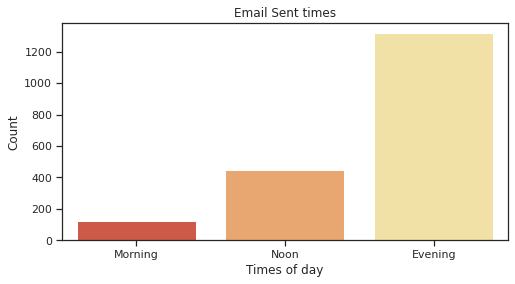

In [264]:
plt.figure(figsize=(8,4))
sns.set_theme(style='ticks',palette='RdYlGn')

sns.countplot(df['times_of_day'],order=df['times_of_day'].value_counts().index[::-1])
plt.xlabel('Times of day')
plt.ylabel('Count')
plt.title('Email Sent times')
plt.show()

Since the data is Ordinal, lets apply Label Encoding the convert the features to Numeric 

--> Evening(2), Noon(1), Morning(0)

In [265]:
df['times_of_day'] = df['times_of_day'].map({"Evening": 2, "Noon": 1, "Morning": 0}).astype("int64")

In [266]:
qualitative_features

['sender',
 'day_of_week',
 'is_weekend',
 'times_of_day',
 'category',
 'is_image',
 'is_personalised',
 'is_quote',
 'is_emoticons',
 'is_discount',
 'is_price',
 'is_urgency',
 'target_audience']

In [267]:
boolean_features = df.filter(like='is').columns
boolean_features

Index(['is_weekend', 'is_image', 'is_personalised', 'is_quote', 'is_emoticons',
       'is_discount', 'is_price', 'is_urgency'],
      dtype='object')

#Interpretations:
As mentioned in the data description the features like ('is_weekend', 'is_image', 'is_personalised', 'is_quote', 'is_emoticons','is_discount', 'is_price', 'is_urgency') are **Boolean values**. But few boolean columns has outliers other than 0 and 1.

So we encoding these values into 0 and 1(data greater than 1 into 1)

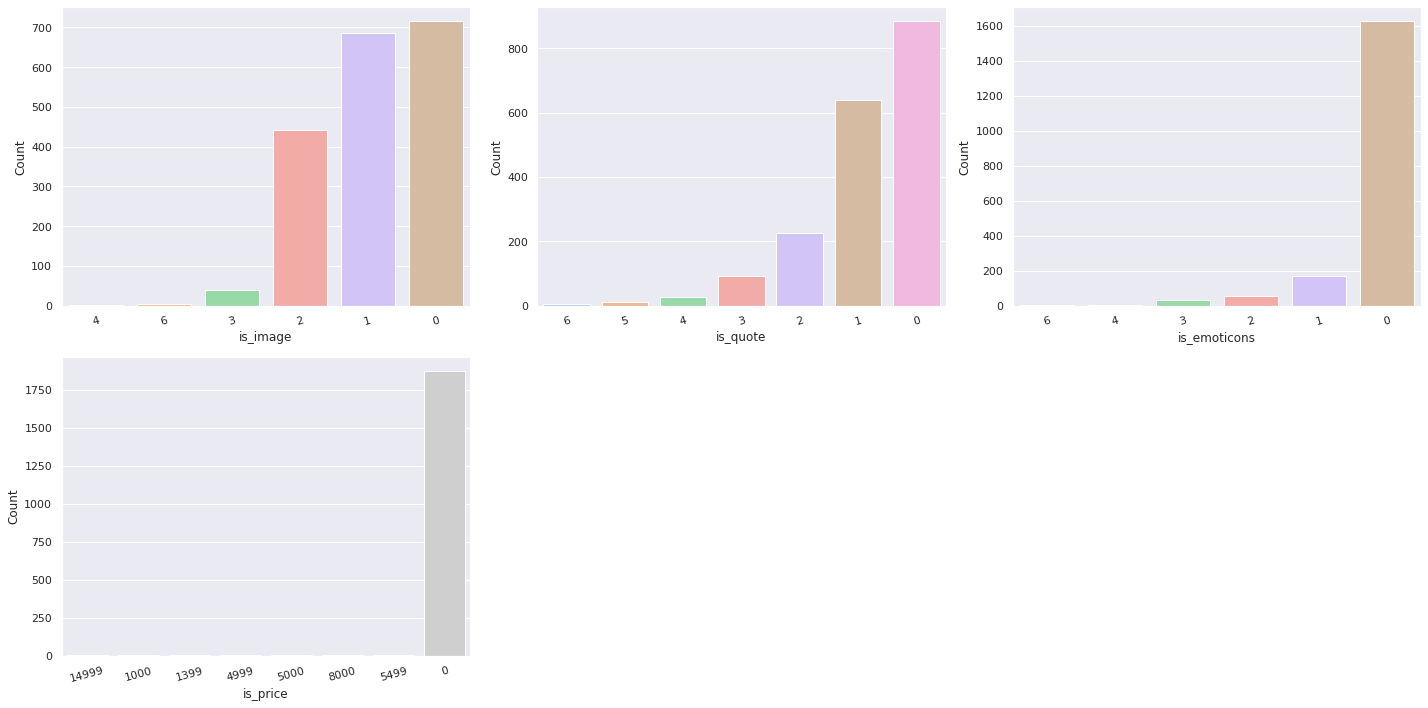

In [268]:
sns.set_theme(style='darkgrid',palette='pastel')

try:
  plt.figure(figsize=(20,10))
  i = 230
  for feature in boolean_features:
    if len(df[feature].unique()) > 2:
      i += 1
      plt.subplot(i)
      sns.countplot(df[feature], order=df[feature].value_counts().index[::-1])
      plt.xticks(rotation=15)
      plt.xlabel(feature)
      plt.ylabel("Count")
except ValueError:
  pass

plt.tight_layout()
plt.show()

From above visualization, we see the values other an boolean values are negligible comparing to 0 and 1. Hence replacing the values greater than 1 into 1(As it represent true value for the data)

In [269]:
for feature in boolean_features:
  df.loc[df[feature] > 1, feature] = 1  

In [270]:
for feature in boolean_features:
  if len(df[feature].unique()) > 2: 
    print(feature)

#Data Visualization
#Feature vs Target
Lets check the relationship of each feature with target

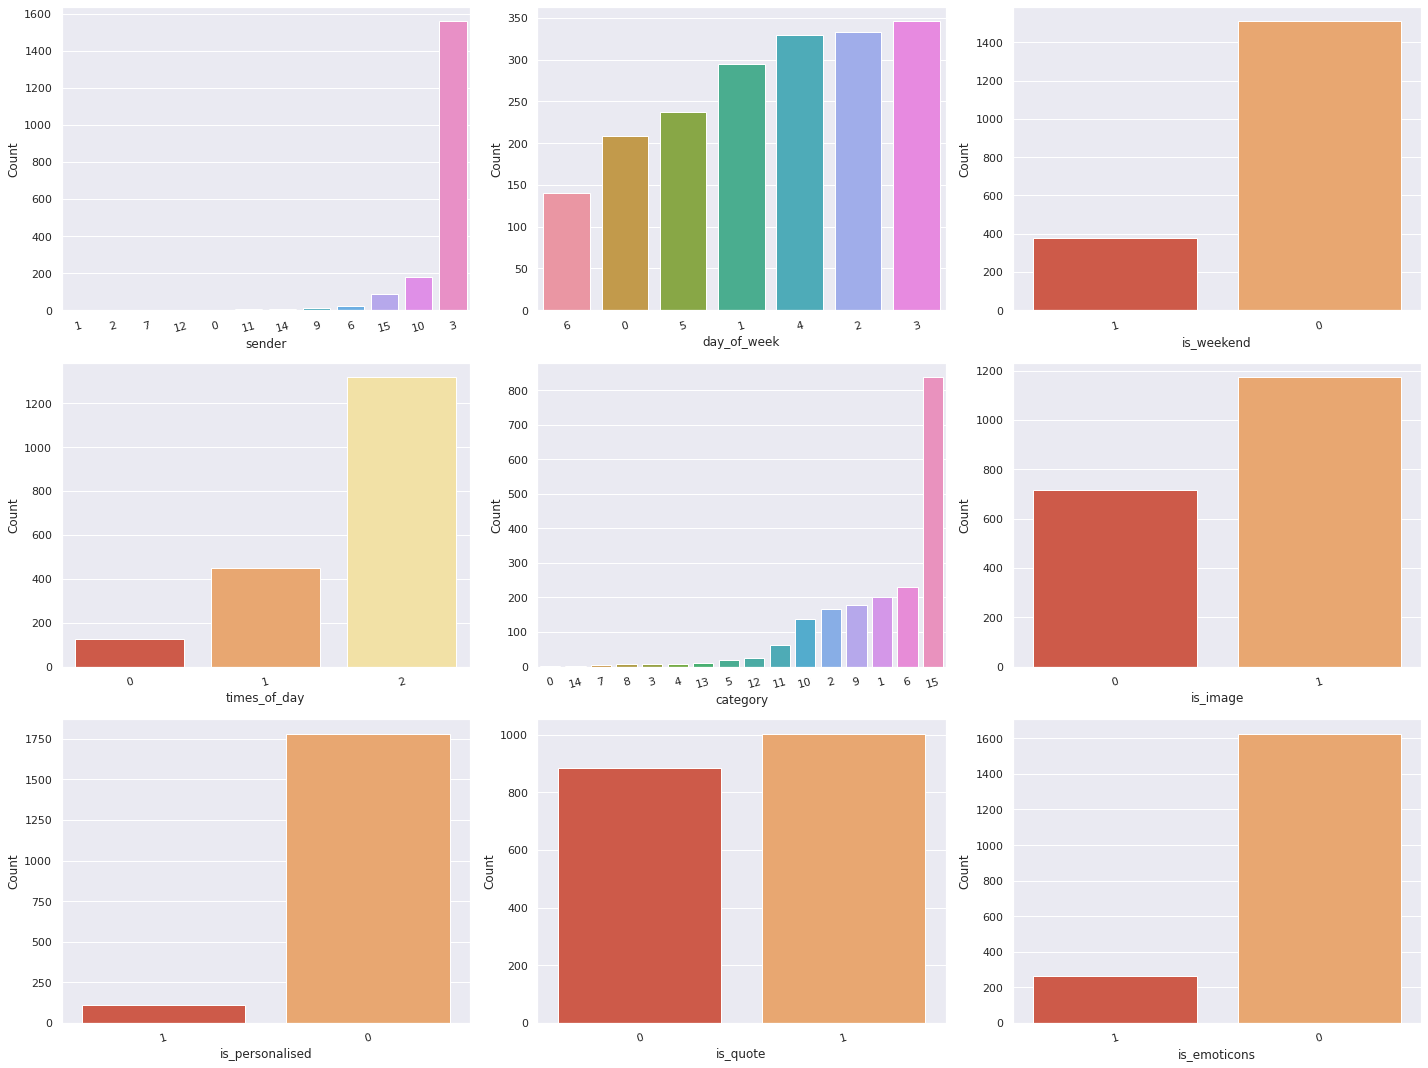

In [271]:
sns.set_theme(style='darkgrid',palette='RdYlGn')

try:
  plt.figure(figsize=(20,15))
  i = 330
  for feature in qualitative_features[:10]:
    i += 1
    plt.subplot(i)
    sns.countplot(df[feature], order=df[feature].value_counts().index[::-1])
    plt.xticks(rotation=15)
    plt.xlabel(feature)
    plt.ylabel("Count")
except ValueError:
  pass

plt.tight_layout()
plt.show()

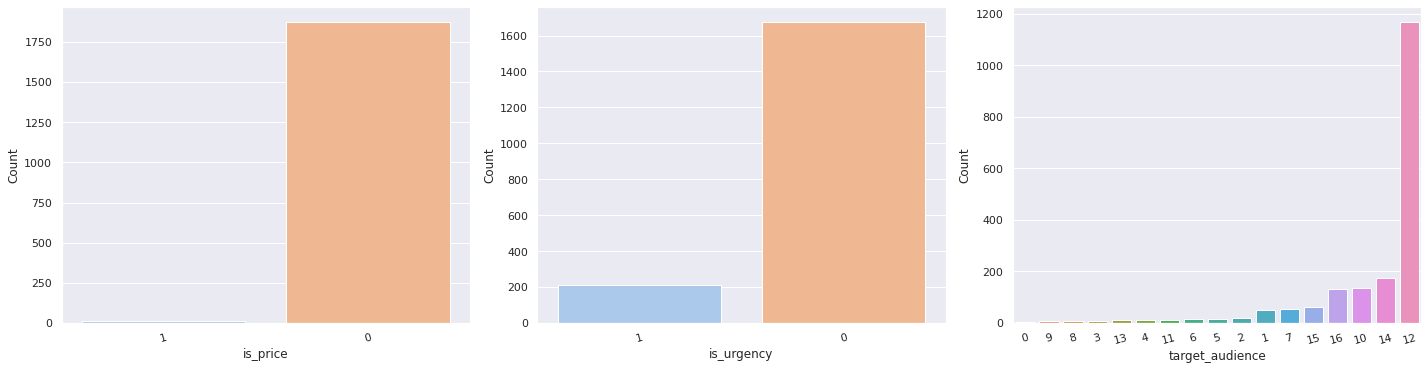

In [272]:
sns.set_theme(style='darkgrid',palette='pastel')

try:
  plt.figure(figsize=(20,15))
  i = 330
  for feature in qualitative_features[10:]:
    i += 1
    plt.subplot(i)
    sns.countplot(df[feature], order=df[feature].value_counts().index[::-1])
    plt.xticks(rotation=15)
    plt.xlabel(feature)
    plt.ylabel("Count")
except ValueError:
  pass

plt.tight_layout()
plt.show()

Since Campaign_ID is unique, lets remove the feature as it will lead to overfitting

Also remove click_rate as that is the target variable to be predicted by the model.

In [273]:
df.drop(["campaign_id"], axis=1, inplace=True)
quantitative_features.remove("campaign_id")
quantitative_features.remove("click_rate")

#Handle Outliers
Since most of the Regression models(Linear Regression, KNN, SVR etc) are sensitive to Outliers, lets check the distribution of data and handle the outliers.

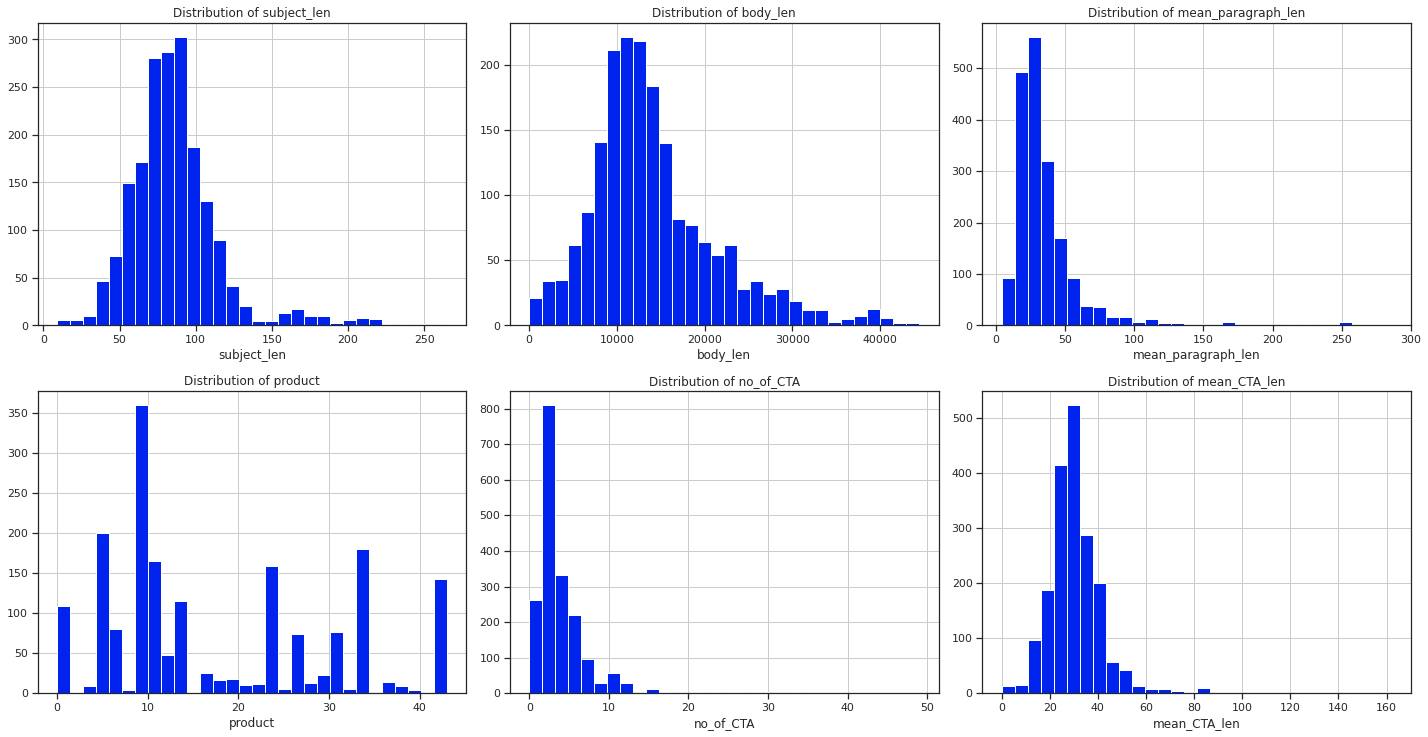

In [274]:
# sns.set_theme(style='whitegrid',palette='pastel')
sns.set_theme(style='ticks',palette="winter")
i = 330
plt.figure(figsize=(20,15))
for feature in quantitative_features:
  i += 1
  plt.subplot(i)
  df[feature].hist(bins=30)
  title1="Distribution of " + feature
  plt.xlabel(feature)
  plt.title(title1)

plt.tight_layout()
plt.show()

From above graph, below is the distribution of data

**Normal Distribution:** subject_len, body_len

**Skewed Distribution:** mean_paragraph_len, no_of_CTA, mean_CTA_len

In [275]:
df["subject_len"].describe()

count    1888.000000
mean       86.246292
std        30.143206
min         9.000000
25%        69.000000
50%        83.000000
75%        98.000000
max       265.000000
Name: subject_len, dtype: float64

The feature: subject_len  is Normally Distributed, but there are Outliers in the data with:
- Mean: 86.24
- Max value: 265

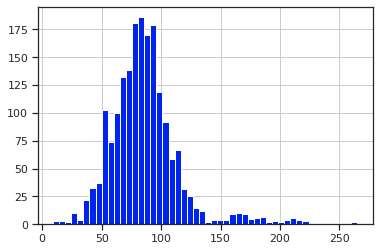

In [276]:
df.subject_len.hist(bins=50)

**Gaussian Distribution Outliers**

If the feature follows a Gaussian Distribution, we calculate the boundaries which differentiate the outliers.

**Skewed Distribution Outliers**

In case of Skewed Distribution, lets calculate the IQR to differentiate the Outliers

In [277]:
sns.set_theme(style='whitegrid',palette='winter')

def plot_graph(dataframe, dataframe1, feature):
  plt.figure(figsize=(15,6))
  plt.subplot(121)
  sns.distplot(dataframe[feature])
  plt.title("Distribution of feature with Outlier")
  plt.subplot(122)
  sns.distplot(dataframe1[feature])
  plt.title("Distribution of feature after removing outliers")

def handle_outlier_Normal_Distribution(feature):
  data = df.copy()
  upper_boundary = data[feature].mean() + 3*data[feature].std()
  lower_boundary = data[feature].mean() - 3*data[feature].std()
  print(upper_boundary)
  data.loc[data[feature] > upper_boundary, feature] = upper_boundary
  plot_graph(df, data, feature)
  plt.tight_layout()
  plt.show()
  df[feature] = data[feature]

def handle_outlier_Skewed_Distribution(feature):
  data = df.copy()
  IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
  lower_fence = df.subject_len.quantile(0.25) - 3*IQR
  upper_fence = df.subject_len.quantile(0.75) + 3*IQR
  data.loc[data[feature] > upper_fence, feature] = upper_fence
  plot_graph(df, data, feature)
  plt.tight_layout()
  plt.show()
  df[feature] = data[feature]


176.6759101674244


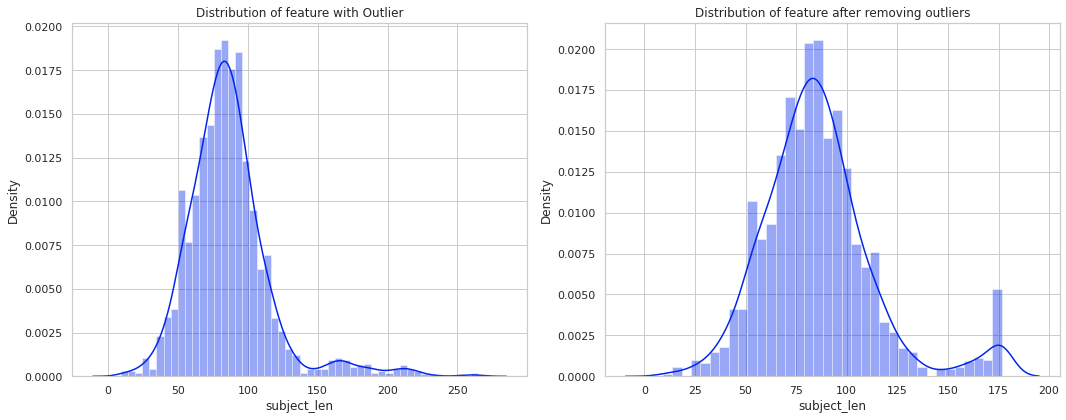

36168.62611112381


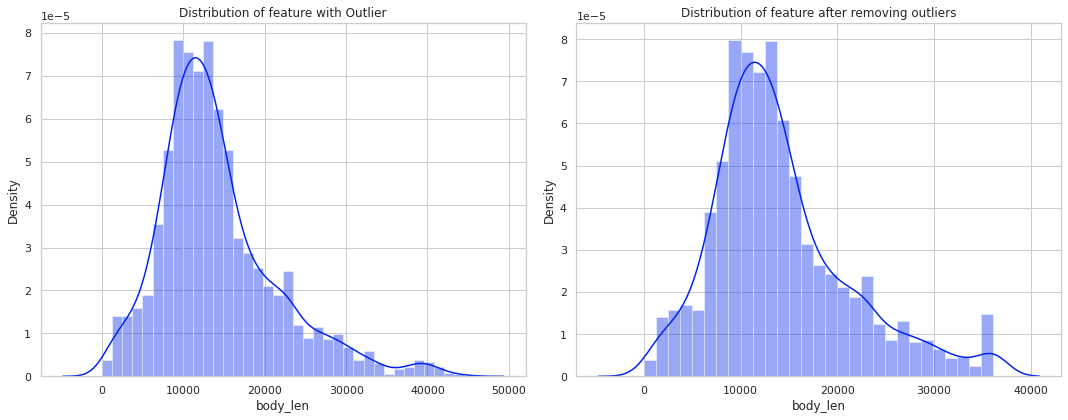

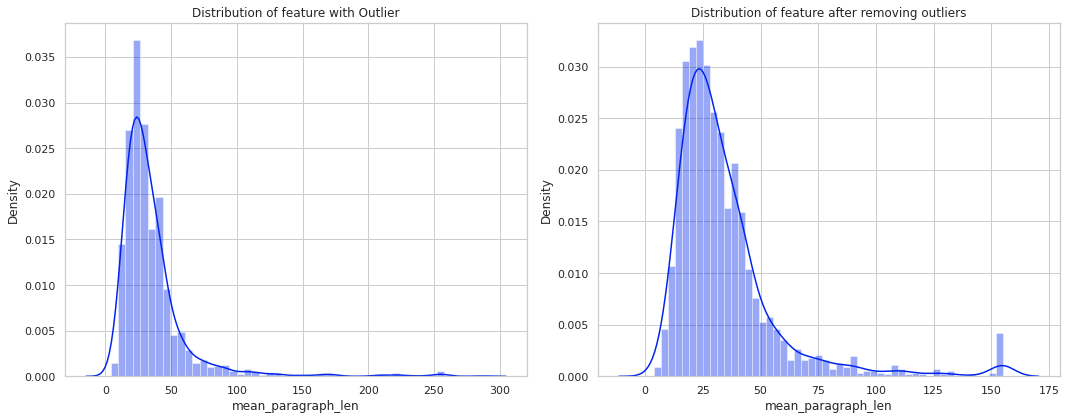

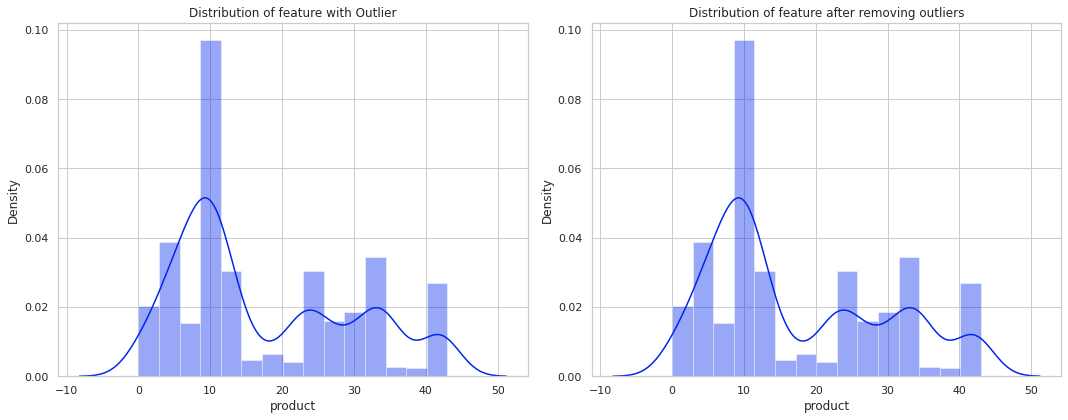

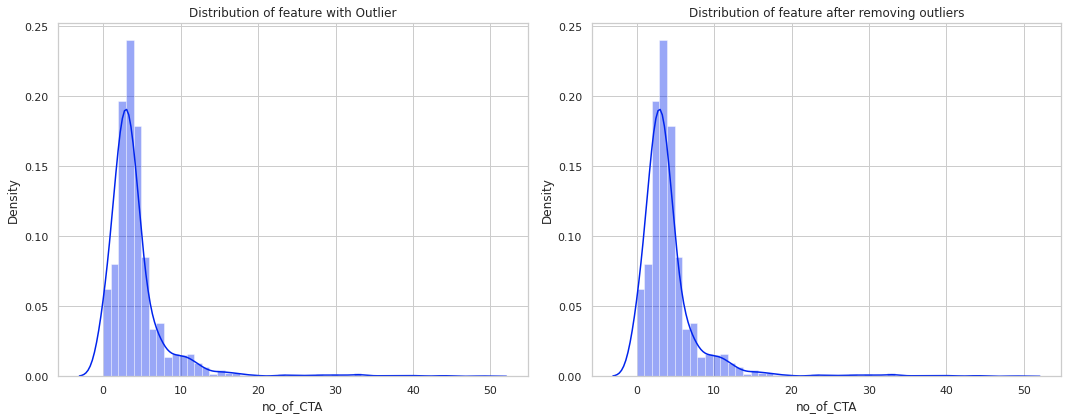

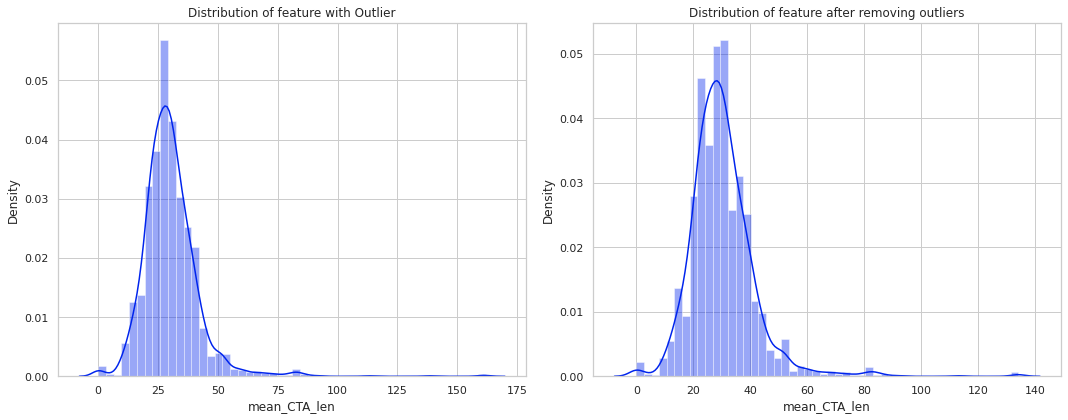

In [278]:
for feature in ['subject_len','body_len']:
  handle_outlier_Normal_Distribution(feature)

for feature in ['mean_paragraph_len', 'product', 'no_of_CTA', 'mean_CTA_len']:
  handle_outlier_Skewed_Distribution(feature)

In [279]:
df["subject_len"].describe()

count    1888.000000
mean       85.612852
std        27.671154
min         9.000000
25%        69.000000
50%        83.000000
75%        98.000000
max       176.675910
Name: subject_len, dtype: float64

#Gaussian Transformation
Many ML algorithms like linear & logistic assumes that that features are Gaussian distributed. Hence checking whether our data is Gaussian Distributed and convert them to Gaussian Distribution using various Transformation methods.

Transformation is performed to increase the accuracy of the model

**Below are few methods used:**

- Logrithmic
- Reciprocal
- SquareRoot
- Exponential

In [280]:
#Function to transform our feature
import numpy as np
def transform(dataframe, feature):
  global df_result
  df_result = pd.DataFrame()
  df_result[feature] = dataframe[feature]
  names = ["Logarithmic", "Reciprocal", "SquareRoot", "Exponential"]
  transformations = [np.log(dataframe[feature]), 1/dataframe[feature], dataframe[feature]**(1/2), dataframe[feature]**(1/1.2)]
  for name, result in zip(names, transformations):
    df_result[name] = result
  return df_result

In [281]:
# np.exp(df["body_len"])

In [282]:
#Draw the histogram and Q-Q plot for the distribution
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plt

def probplot(dataframe, feature):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  dataframe[feature].hist()
  plt.subplot(1,2,2)
  stats.probplot(dataframe[feature], dist="norm", plot=pylab)
  plt.show()


subject_len


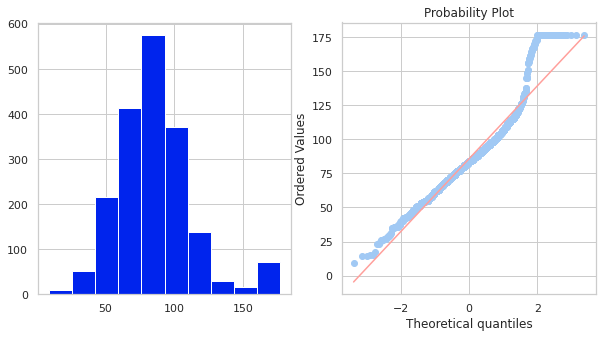

Logarithmic


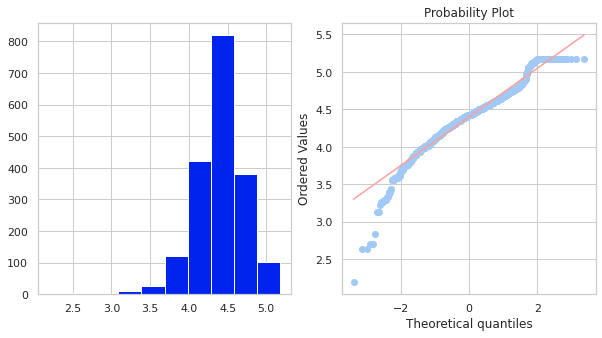

Reciprocal


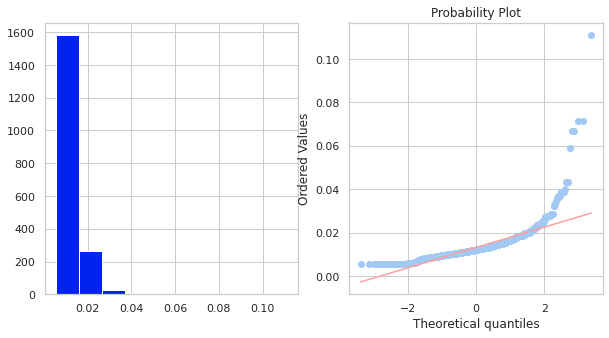

SquareRoot


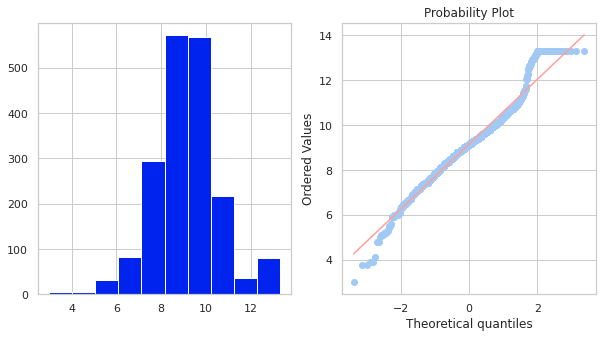

Exponential


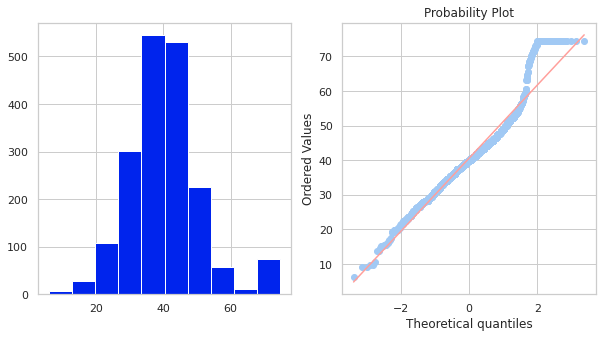

In [283]:
#Check the Distribution of Feature: Subject Length on different Transformation
df_result = transform(df, "subject_len")
for data in df_result.columns.values:
  print(data)
  probplot(df_result, data)

From Above Q-Q plot, we see subject length follows a Normal Distribution when converted to Squareroot.

In [284]:
df["subject_len"] = df["subject_len"]**(1/2)

body_len


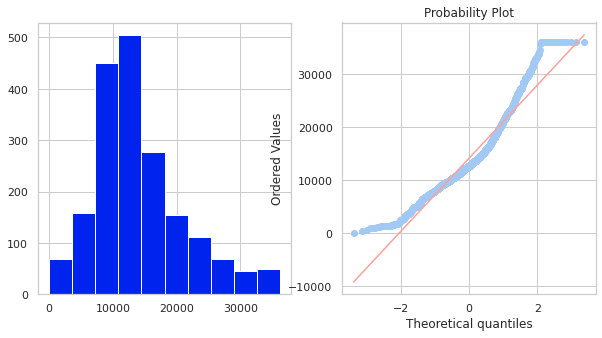

Logarithmic


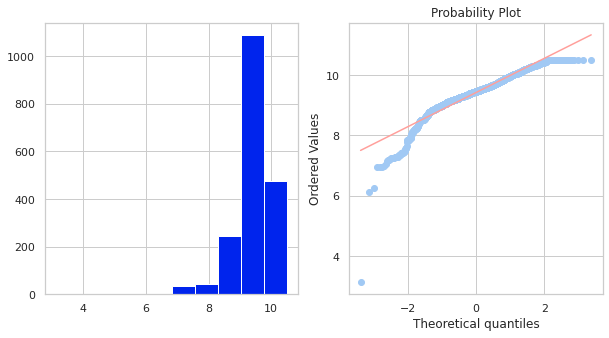

Reciprocal


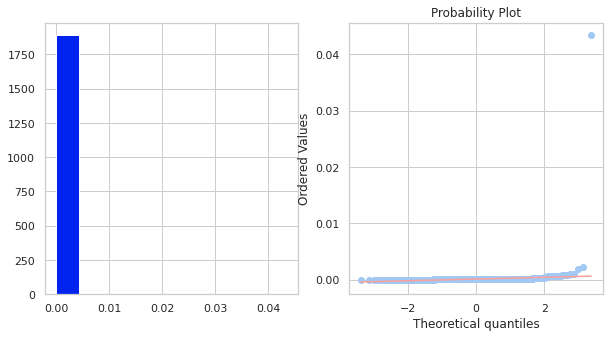

SquareRoot


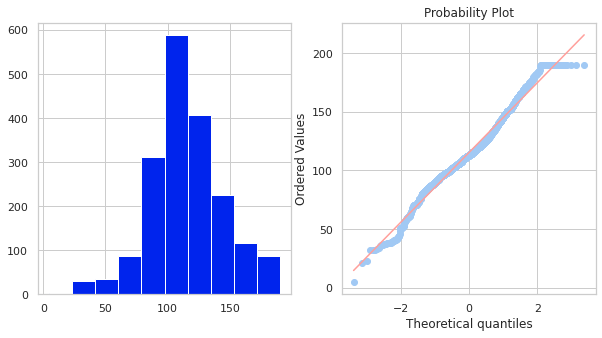

Exponential


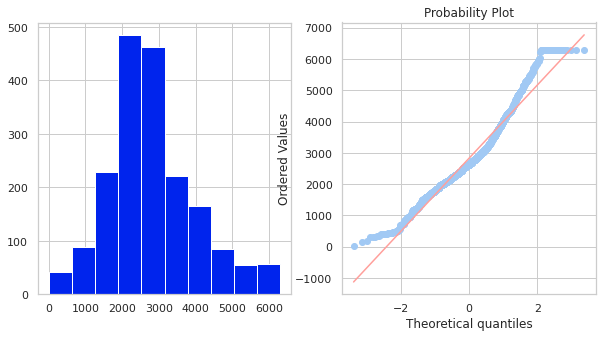

In [285]:
df_result = transform(df, "body_len")
for data in df_result.columns.values:
  print(data)
  probplot(df_result, data)

Feature: Body_len Distribution

Feature: "body_len" follows a normal distrition when Exponential transformation is applied.

In [286]:
df["body_len"] = df["body_len"]**(1/2)

mean_paragraph_len


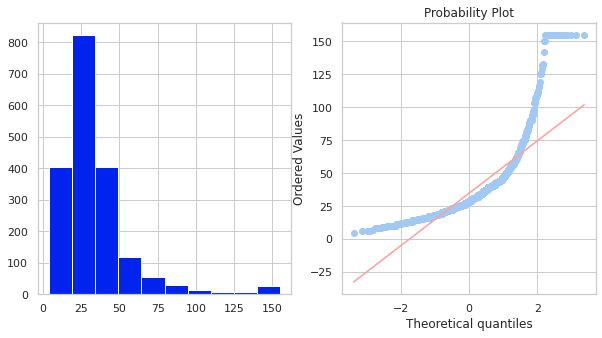

Logarithmic


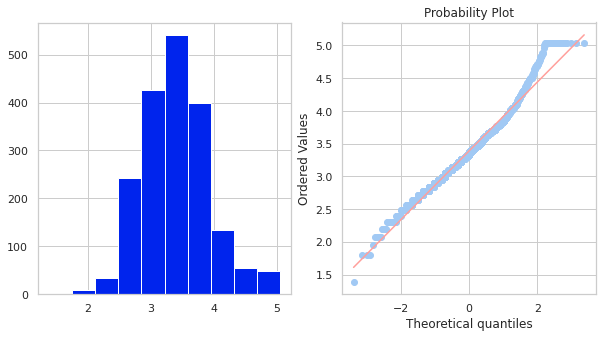

Reciprocal


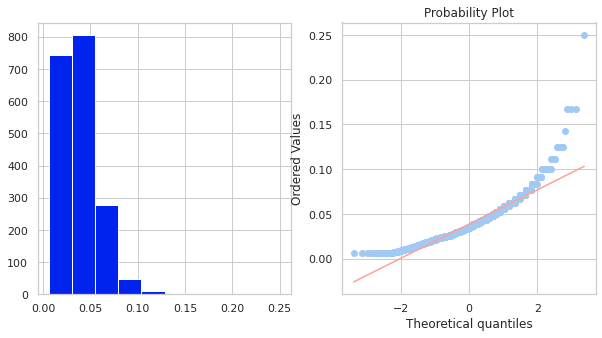

SquareRoot


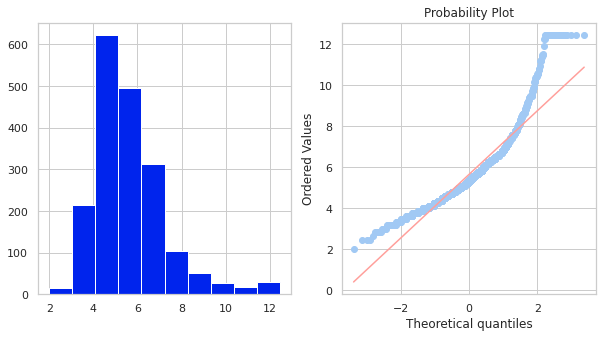

Exponential


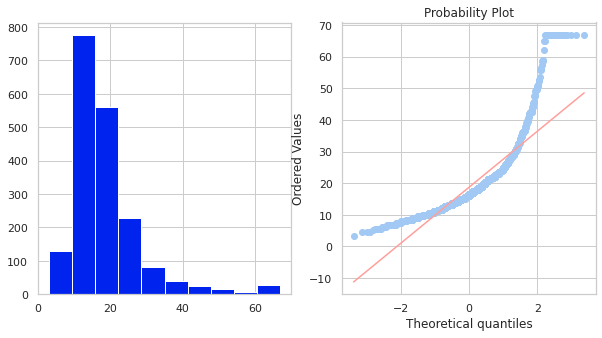

In [287]:
df_result = transform(df, "mean_paragraph_len")
for data in df_result.columns.values:
  print(data)
  probplot(df_result, data)

Feature: mean_paragraph_len is converted to Normal distrution if Logarithmic Transformation is applied.

In [288]:
df["mean_paragraph_len"] = np.log(df["mean_paragraph_len"])

In [289]:
# df[['product','no_of_CTA','mean_CTA_len','click_rate']].corr()
df["mean_CTA_len"].describe()

count    1888.000000
mean       30.202331
std        11.542477
min         0.000000
25%        23.000000
50%        29.000000
75%        35.000000
max       134.000000
Name: mean_CTA_len, dtype: float64

Since the correlation value between "product", "no_of_CTA", "mean_CTA_len" and "click_rate" is less than 0.2, we are dropping these 3 features.

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



product


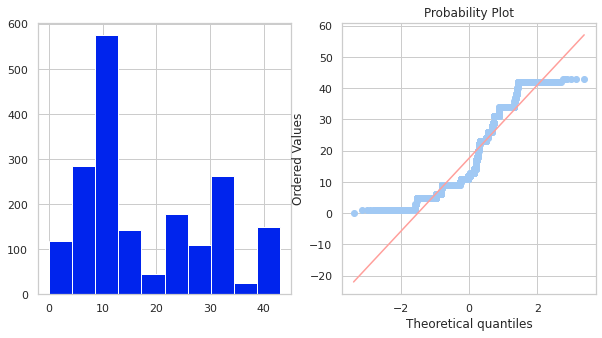

SquareRoot


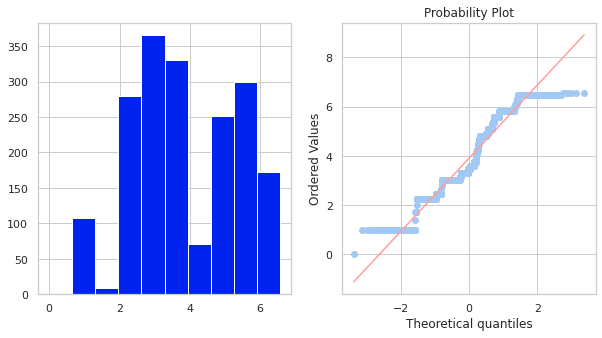

Exponential


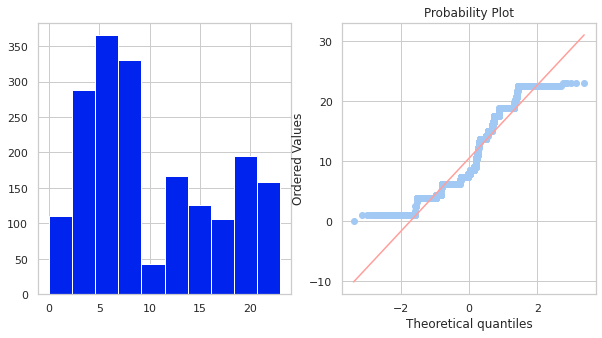

In [290]:
df_result = transform(df, "product")
# for data in df_result.columns.values:
for data in ["product", "SquareRoot", "Exponential"]:
  print(data)
  probplot(df_result, data)


In [291]:
df[["product", "click_rate"]].corr()

,product,click_rate
product,1.000000,0.121602
click_rate,0.121602,1.000000


Since we are unable to transform Feature: Product into Normal distribution, using any of the transformation technique. 

Also there is very less correlation between Product and Click Rate, we are dropping the feature from the datasets.

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



no_of_CTA


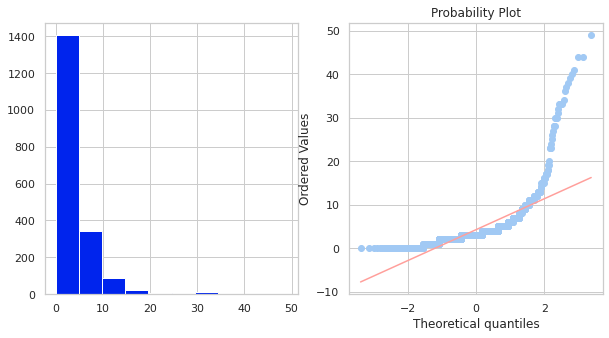

SquareRoot


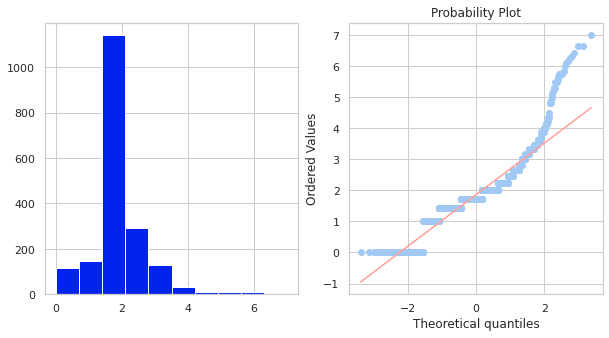

Exponential


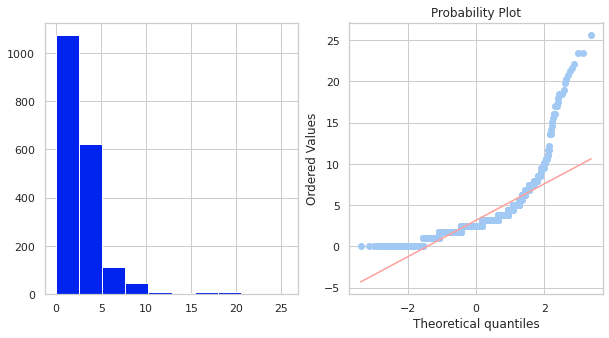

In [292]:
df_result = transform(df, "no_of_CTA")
# for data in df_result.columns.values:
for data in ["no_of_CTA", "SquareRoot", "Exponential"]:
  print(data)
  probplot(df_result, data)

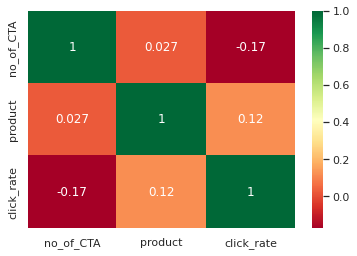

In [293]:
new_corr_matrix = df[["no_of_CTA", "product", "click_rate"]].corr()
sns.heatmap(new_corr_matrix,annot=True,cmap='RdYlGn')

Similarly, unable to transform them into Normal Distribution using transformation techniques. Also, no_of_CTA has very less correlation with output feature.

**Let's drop Features: Product, no_of_CTA**

In [294]:
df.drop(["product", "no_of_CTA"], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



mean_CTA_len


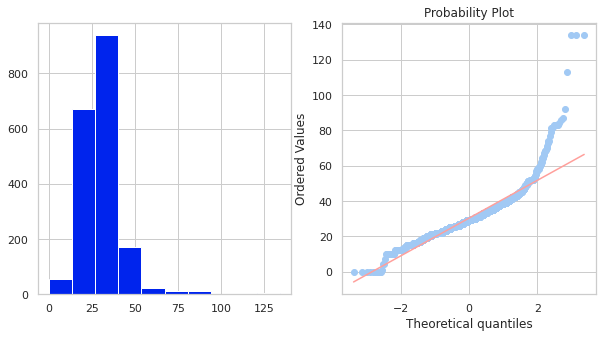

SquareRoot


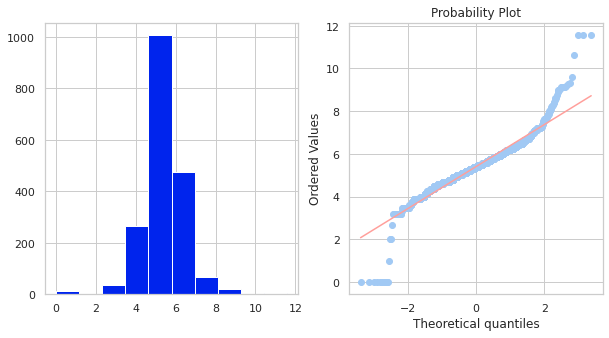

Exponential


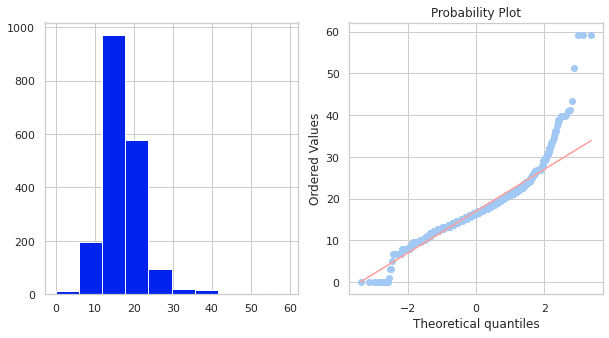

In [295]:
df_result = transform(df, "mean_CTA_len")
# for data in df_result.columns.values:
for data in ["mean_CTA_len", "SquareRoot", "Exponential"]:
  print(data)
  probplot(df_result, data)

Feature: "mean_CTA_len", almost follows a Normal Distribution, when Squareroot transformation is applied to the data.

In [296]:
df["mean_CTA_len"] = df["mean_CTA_len"]**(1/2)

Since this is Regression problem, lets check the relationship between feature and target:
- Is there a relationship between the feature and target?
- Is there a linear relationship between the feature and target?

df["body_len"].sort_values(ascending=False)

In [297]:
for feature in df.columns:
  if len(df[feature].unique()) < 25:
    qualitative_features.append(feature)
    print("Feature: {} has {} classes --> {}".format(feature, len(df[feature].unique()), sorted(df[feature].unique())))

Feature: sender has 12 classes --> [0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 14, 15]
Feature: day_of_week has 7 classes --> [0, 1, 2, 3, 4, 5, 6]
Feature: is_weekend has 2 classes --> [0, 1]
Feature: times_of_day has 3 classes --> [0, 1, 2]
Feature: category has 16 classes --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Feature: is_image has 2 classes --> [0, 1]
Feature: is_personalised has 2 classes --> [0, 1]
Feature: is_quote has 2 classes --> [0, 1]
Feature: is_emoticons has 2 classes --> [0, 1]
Feature: is_discount has 2 classes --> [0, 1]
Feature: is_price has 2 classes --> [0, 1]
Feature: is_urgency has 2 classes --> [0, 1]
Feature: target_audience has 17 classes --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [298]:
#orders for all the barplots in ascending order
sender = df.groupby('sender')['click_rate'].mean().reset_index().sort_values('click_rate')['sender']
day_of_week = df.groupby('day_of_week')['click_rate'].mean().reset_index().sort_values('click_rate')['day_of_week']
times_of_day = df.groupby('times_of_day')['click_rate'].mean().reset_index().sort_values('click_rate')['times_of_day']
category = df.groupby('category')['click_rate'].mean().reset_index().sort_values('click_rate')['category']
is_image = df.groupby('is_image')['click_rate'].mean().reset_index().sort_values('click_rate')['is_image']
is_quote = df.groupby('is_quote')['click_rate'].mean().reset_index().sort_values('click_rate')['is_quote']
is_image = df.groupby('is_image')['click_rate'].mean().reset_index().sort_values('click_rate')['is_image']
is_emoticons = df.groupby('is_emoticons')['click_rate'].mean().reset_index().sort_values('click_rate')['is_emoticons']
is_price = df.groupby('is_price')['click_rate'].mean().reset_index().sort_values('click_rate')['is_price']
target_audience = df.groupby('target_audience')['click_rate'].mean().reset_index().sort_values('click_rate')['target_audience']

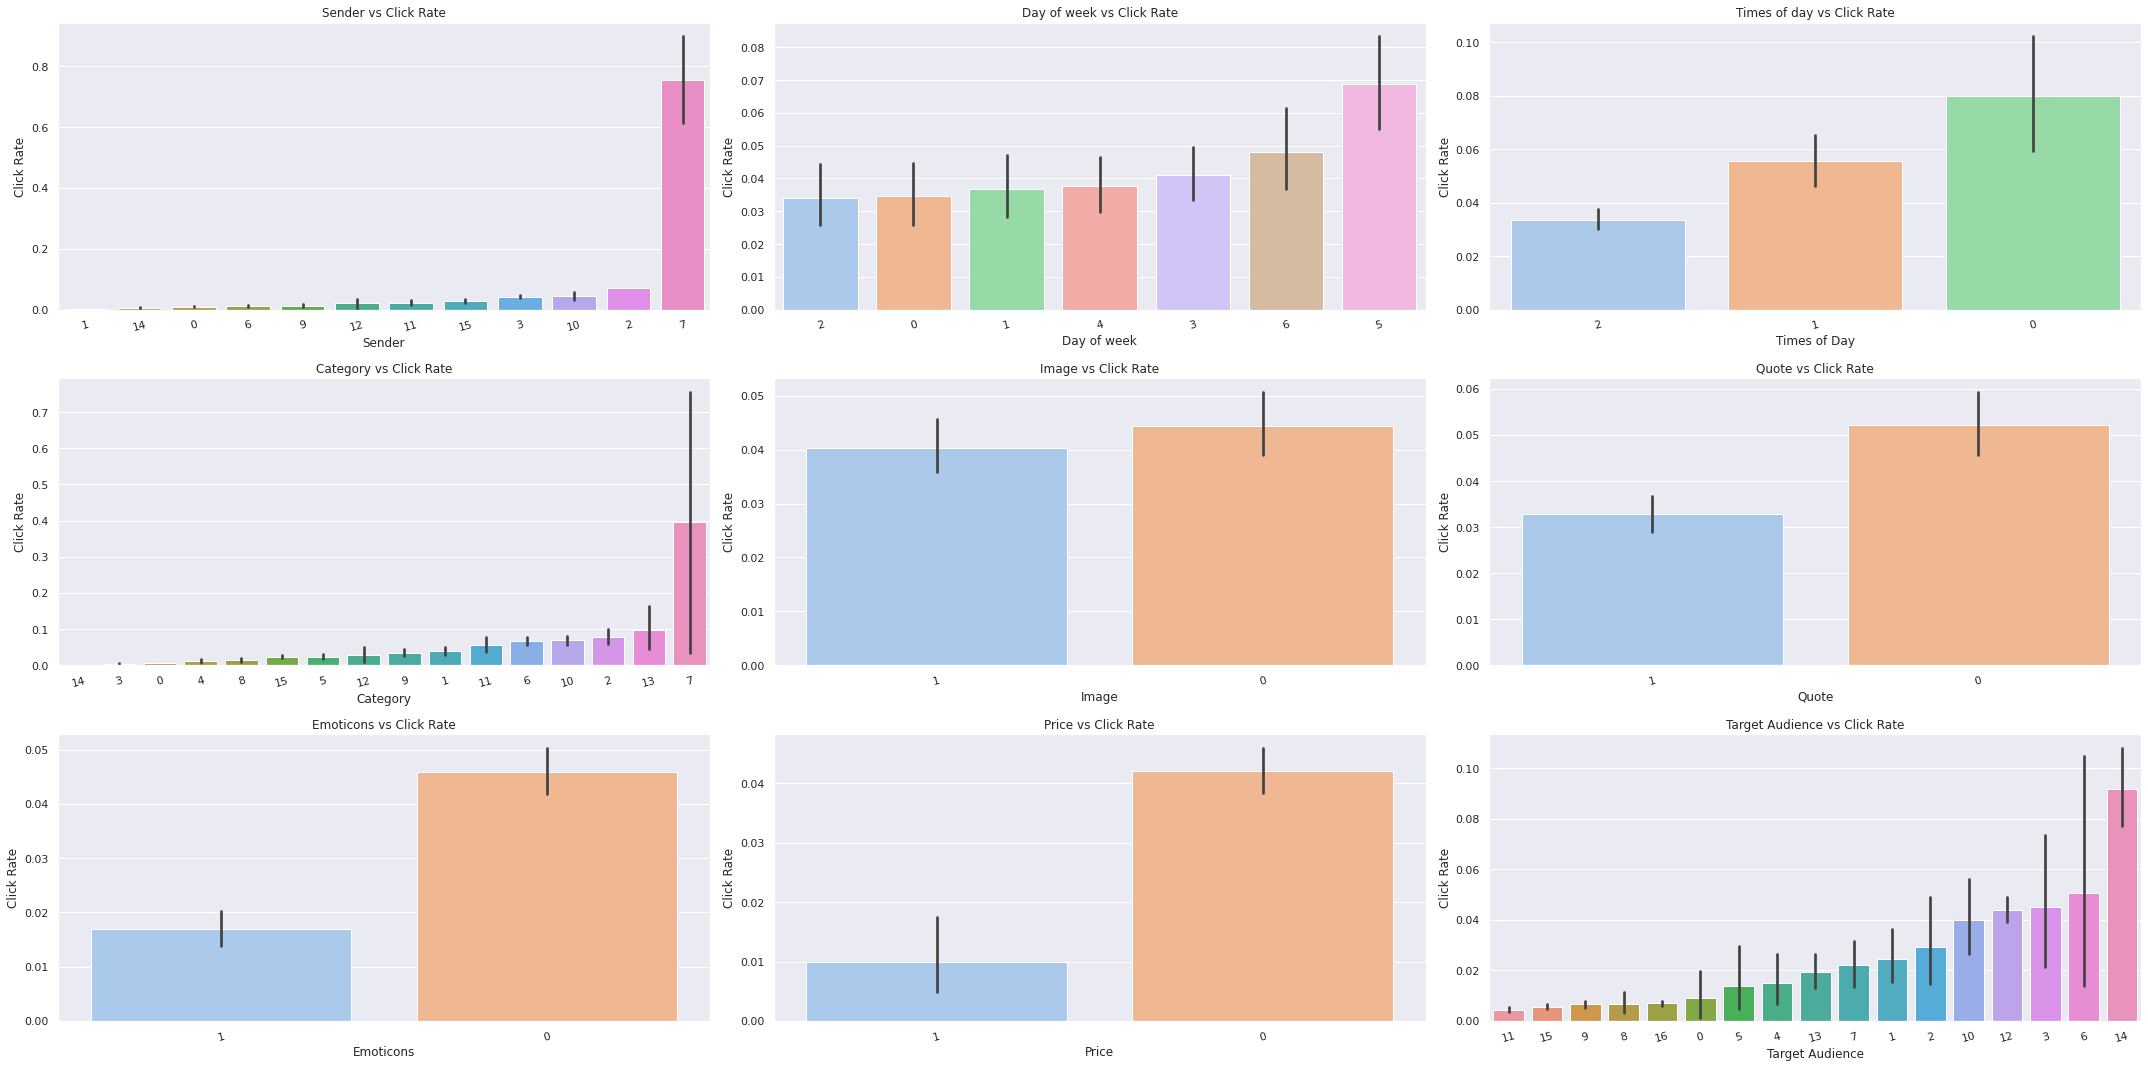

In [299]:
#plotting count plots for all the categorical columns
sns.set_theme(style='darkgrid',palette='pastel')

plt.figure(figsize=(30,15))

plt.subplot(331)
sns.barplot(df['sender'],df['click_rate'],order=sender)
plt.xticks(rotation=15)
plt.xlabel('Sender')
plt.ylabel('Click Rate')
plt.title('Sender vs Click Rate')

plt.subplot(332)
sns.barplot(df['day_of_week'],df['click_rate'],order=day_of_week)
plt.xticks(rotation=15)
plt.xlabel('Day of week')
plt.ylabel('Click Rate')
plt.title('Day of week vs Click Rate')

plt.subplot(333)
sns.barplot(df['times_of_day'],df['click_rate'],order=times_of_day)
plt.xticks(rotation=15)
plt.xlabel('Times of Day')
plt.ylabel('Click Rate')
plt.title('Times of day vs Click Rate')

plt.subplot(334)
sns.barplot(df['category'],df['click_rate'],order=category)
plt.xticks(rotation=15)
plt.xlabel('Category')
plt.ylabel('Click Rate')
plt.title('Category vs Click Rate')

plt.subplot(335)
sns.barplot(df['is_image'],df['click_rate'],order=is_image)
plt.xticks(rotation=15)
plt.xlabel('Image')
plt.ylabel('Click Rate')
plt.title('Image vs Click Rate')

plt.subplot(336)
sns.barplot(df['is_quote'],df['click_rate'],order=is_quote)
plt.xticks(rotation=15)
plt.xlabel('Quote')
plt.ylabel('Click Rate')
plt.title('Quote vs Click Rate')

plt.subplot(337)
sns.barplot(df['is_emoticons'],df['click_rate'],order=is_emoticons)
plt.xticks(rotation=15)
plt.xlabel('Emoticons')
plt.ylabel('Click Rate')
plt.title('Emoticons vs Click Rate')

plt.subplot(338)
sns.barplot(df['is_price'],df['click_rate'],order=is_price)
plt.xticks(rotation=15)
plt.xlabel('Price')
plt.ylabel('Click Rate')
plt.title('Price vs Click Rate')

plt.subplot(339)
sns.barplot(df['target_audience'],df['click_rate'],order=target_audience)
plt.xticks(rotation=15)
plt.xlabel('Target Audience')
plt.ylabel('Click Rate')
plt.title('Target Audience vs Click Rate')


plt.tight_layout()
plt.show()

In [300]:
df

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,mean_CTA_len,is_image,is_personalised,is_quote,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,3,8.717798,102.171425,3.663562,5,1,1,6,5.385165,0,0,0,0,0,0,0,14,0.103079
1,3,7.348469,50.695167,5.043425,5,1,0,2,4.690416,0,0,0,0,0,0,0,10,0.700000
2,3,7.681146,113.141504,2.772589,5,1,1,2,4.795832,1,0,1,0,0,0,0,16,0.002769
3,3,8.602325,105.057127,3.401197,4,0,2,15,4.898979,0,0,0,0,0,0,0,10,0.010868
4,3,8.944272,100.054985,3.295837,5,1,1,6,5.567764,0,0,1,0,0,0,0,14,0.142826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,3,9.380832,38.091994,4.317488,2,0,1,2,4.690416,0,0,1,0,0,0,0,10,0.350746
1884,3,7.615773,102.649890,3.688879,2,0,2,2,5.196152,0,0,0,0,0,0,0,11,0.004728
1885,3,9.433981,105.118980,3.258097,1,0,2,15,5.291503,0,0,0,0,0,0,0,6,0.008289
1886,3,7.615773,102.649890,3.688879,1,0,2,2,5.196152,0,0,0,0,0,0,0,16,0.012014


#Segregating Dataset into X & Y

In [306]:
x_train = df.drop("click_rate",axis=1)
y_train = df["click_rate"]

In [313]:
df_test = pd.read_csv("https://raw.githubusercontent.com/Jaiprakash91194/CTR_Email_Campaign/main/test_data.csv")

In [314]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
tr_x_train = ss.transform(x_train)

In [316]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(tr_x_train,y_train)

LinearRegression()

In [317]:
df.head()

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,mean_CTA_len,is_image,is_personalised,is_quote,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,3,8.717798,102.171425,3.663562,5,1,1,6,5.385165,0,0,0,0,0,0,0,14,0.103079
1,3,7.348469,50.695167,5.043425,5,1,0,2,4.690416,0,0,0,0,0,0,0,10,0.700000
2,3,7.681146,113.141504,2.772589,5,1,1,2,4.795832,1,0,1,0,0,0,0,16,0.002769
3,3,8.602325,105.057127,3.401197,4,0,2,15,4.898979,0,0,0,0,0,0,0,10,0.010868
4,3,8.944272,100.054985,3.295837,5,1,1,6,5.567764,0,0,1,0,0,0,0,14,0.142826


In [318]:
df_test.head()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience
0,1889,3,61,12871,11,6,1,Noon,6,26,3,37,1,0,0,0,1,0,0,0,14
1,1890,3,54,2569,256,5,1,Morning,2,11,0,22,0,0,0,0,0,0,0,0,10
2,1891,3,88,1473,78,4,0,Evening,2,11,0,22,1,0,1,0,0,0,0,0,10
3,1892,3,88,1473,78,3,0,Evening,2,11,0,22,1,0,1,0,0,0,0,0,10
4,1893,3,78,9020,29,3,0,Noon,6,26,2,40,0,0,0,0,0,0,0,0,14


#Feature Engineering in Training data
Below are the Feature Engineering techniques performed on Training data:

**Encoding**:
- times_of_day --> Since data is Ordinal, mapped the text data to numeric based on the data weightage --> **Evening(2), Noon(1), Morning(0)**

**Features Selection:**
- campaign_id --> Removed since it will lead to model overfitting
- is_timer --> Removed as it has only one class, and Doesn't affect the performance of the model.
- product, no_of_CTA --> Removed as it doesn't follow Normal Distribution. Also unable to transform to Normal Distribution them using transformation techniques.

**Feature Transformation:**
- subject_len --> Square Root Transformation
- body_len --> Exponential Transformation
- mean_paragraph_len --> Logarithmic Transformation
- mean_CTA_len --> Square Root Transformation


**Boolean Value convertion:**

- As mentioned in the data description the features like ('is_weekend', 'is_image', 'is_personalised', 'is_quote', 'is_emoticons','is_discount', 'is_price', 'is_urgency') are Boolean values. But few boolean columns has outliers other than 0 and 1.

- So we are  encoding these values into 0 and 1(data greater than 1 into 1)

In [333]:
def feature_eng(dataframe):
  dataframe['times_of_day'] = dataframe['times_of_day'].map({"Evening": 2, "Noon": 1, "Morning": 0}).astype("int64")
  for feature in dataframe.filter(like='is').columns:
    dataframe.loc[dataframe[feature] > 1, feature] = 1 
  dataframe.drop(["campaign_id", "is_timer", "product", "no_of_CTA"], axis=1, inplace=True)
  dataframe["subject_len"] = dataframe["subject_len"]**(1/2)
  dataframe["body_len"] = dataframe["body_len"]**(1/1.2)
  dataframe["mean_paragraph_len"] = np.log(dataframe["mean_paragraph_len"])
  dataframe["mean_CTA_len"] = dataframe["mean_CTA_len"]**(1/2)
  return dataframe

In [334]:
df_test = pd.read_csv("https://raw.githubusercontent.com/Jaiprakash91194/CTR_Email_Campaign/main/test_data.csv")
df_test1 = feature_eng(df_test)
df_test1.head()

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,mean_CTA_len,is_image,is_personalised,is_quote,is_emoticons,is_discount,is_price,is_urgency,target_audience
0,3,7.810250,2658.746362,2.397895,6,1,1,6,6.082763,1,0,0,1,0,0,0,14
1,3,7.348469,694.176787,5.545177,5,1,0,2,4.690416,0,0,0,0,0,0,0,10
2,3,9.380832,436.685685,4.356709,4,0,2,2,4.690416,1,0,1,0,0,0,0,10
3,3,9.380832,436.685685,4.356709,3,0,2,2,4.690416,1,0,1,0,0,0,0,10
4,3,8.831761,1976.994440,3.367296,3,0,1,6,6.324555,0,0,0,0,0,0,0,14


In [335]:
df.head()

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,mean_CTA_len,is_image,is_personalised,is_quote,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,3,8.717798,102.171425,3.663562,5,1,1,6,5.385165,0,0,0,0,0,0,0,14,0.103079
1,3,7.348469,50.695167,5.043425,5,1,0,2,4.690416,0,0,0,0,0,0,0,10,0.700000
2,3,7.681146,113.141504,2.772589,5,1,1,2,4.795832,1,0,1,0,0,0,0,16,0.002769
3,3,8.602325,105.057127,3.401197,4,0,2,15,4.898979,0,0,0,0,0,0,0,10,0.010868
4,3,8.944272,100.054985,3.295837,5,1,1,6,5.567764,0,0,1,0,0,0,0,14,0.142826
